# Machine Learning in Python - Project 1

## Setup

In [1]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split,KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load data in easyshare.csv
d = pd.read_csv("easyshare.csv")
d.head()

,mergeid,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,...,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
0,AT-000674-01,2011.0,4.0,11.0,40.0,1.0,59.700001,40.0,40.0,5.0,...,2.0,5.0,5.0,5.0,1.0,44.0,1.0,5.0,2.0,8.0
1,AT-001215-01,2011.0,4.0,11.0,40.0,1.0,72.599998,528.0,528.0,5.0,...,3.0,1.0,1.0,2.0,1.0,35.0,6.0,1.0,0.0,14.5
2,AT-001492-01,2011.0,4.0,11.0,40.0,1.0,59.599998,40.0,40.0,3.0,...,2.0,5.0,1.0,7.0,2.0,43.0,1.0,5.0,6.0,18.5
3,AT-001492-02,2011.0,4.0,11.0,40.0,0.0,59.799999,40.0,40.0,4.0,...,2.0,1.0,1.0,7.0,3.0,47.0,1.0,NaN,6.0,24.0
4,AT-001816-01,2004.0,1.0,11.0,40.0,1.0,61.299999,40.0,40.0,3.0,...,2.0,5.0,1.0,4.0,3.0,43.0,0.0,5.0,2.0,20.0


In [3]:
# Helper functions: 
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [4]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

# Introduction
Dementia is a significant global public health issue, with over 55 million people affected worldwide and nearly 10 million new cases reported each year (World Health Organization, [1]). Understanding the factors that contribute to the early onset of this condition or may worsen its symptoms can prove immensely valuable. Thus, as the team of Data Scientists Consusltants hired by the European Union, we are endeavoring to shed some light into which variables are the most impactful related to dementia within the scope of this project.

To accomplish this objective, we employed the `easyshare.csv` dataset, utilizing `cogscore` as a proxy measure for dementia severity. We studied and selected the most appropriate features in the dataset. Our analysis involved thorough preprocessing and feature selection to ensure the quality and relevance of the data. Additionally, we conducted extensive testing using a variety of machine learning models, including linear, polynomial, lasso, ridge, and elastic net regression. In the Model Fitting and Tuning section, we will showcase the outcome of our most precise model and discuss why other models were deemed less suitable. Ultimately, we aim to provide guidance to the public on modifiable risk factors to mitigate the risk of dementia based on empirical data.

It is important to note the exceptional challenges in predicting dementia due to its multifaceted nature. Achieving a flawless model which predicts this complex syndrome, with our current machine learning techniques, is nearly impossible. Nonetheless, we are confident that our findings will contribute to better understanding of the factors at play and their effect on dementia prevention efforts.


# Exploratory Data Analysis and Feature Engineering

#### Data pre-processing and data cleaning
Our analysis began with an in-depth exploration of the `easyshare.csv` dataset through exploratory data analysis (EDA). We examined its structure and content, which encompassed details on diverse demographic, health, and lifestyle factors of individuals from various countries. We observed that our dataset comprises of the total of 98,348 entries across 23 column, with each column representing specific attributes such as age, gender, education level, and cognitive score (`cogscore`). 

To prepare the data for analysis, we performed several preprocessing steps, carefully considering the nature of each attribute. We transformed some columns for better interpretability by renaming them with more descriptive labels. For instance, `br010_mod` was renamed to `drinking` and `br015_` to `activity`, reflecting their categorical nature. Additionally, we identified binary and categorical data attributes such as `female`, `drinking`, `activity`, `smoking`, and `ever_smoked`, while `bmi2`, `depression` (formerly `eurod`), `edulevel` (formerly `isced1997_r`), and `casp` were treated as ordinal.

#### Data reduction
The following columns were removed for various reasons:
- `wave` and `int_year` were excluded to prevent potential influence on cognitive scores by interview year or wave group given that the cognitive scores of the interviewees is not impacted by these variables.
- `country`, `citizenship`, and `birth_country` were highly correlated and thus removed to avoid multicollinearity issues, retaining `country_mod` which is already standardazed based on ISO codes of countries and its easier to interpret in subsequent analysis.
- `bmi` was replaced by `bmi2` for improved categorization.
- `eduyears_mod` was removed due to its high correlation with `edu_level`.
- `ever_smoked` was deemed redundant and removed in favor of retaining `smoking`.

Missing values were addressed by dropping all rows with null values, with columns removed first to prevent inadvertent loss of additional rows.

Furthermore, `country_mod` was replaced by `region` based on countries' ISO codes to facilitate regional analysis, enhancing interpretability given the dataset's predominantly EU-centric composition. This categorization enables the exploration of potential regional variations in demographic, health, and lifestyle factors and their impact on cognitive scores.

#### Data partitioning
To validate different models and compare their efficiency, the data was partitioned as follows:
- A training set (`X_train`) and its corresponding labels (`y_train`, `cogscore`) consisting of 70% of the cleaned data.
- A validation set (`X_val`) and its labels (`y_val`, `cogscore`) comprising 15% of the cleaned dataset.The comparison of different models and the selection of the most efficient one were based on the utilization of this validation set. 
- A test set (`X_test`) and its labels (`y_test`, `cogscore`) with the remaining cleaned data.

#### Data transformation and feature engineering
As highlighted above, we employed feature selection to reduce the number of variables processed by the model. To address the curse of dimensionality, principal component analysis (PCA) was applied to merge features such as `drinking`, `smoking`, `casp`, `depression`, `bmi2`, `chronic_mod`, and `activity` into a comprehensive variable named `lifestyle`. This new variable, corresponds to the first principal component derived from conducting PCA on the `X_train` data, effectively summarized these features.

During the principal component analysis we encoded the features as follows:
- `drinking`, `bmi2` and `activity` as *ordinal* categorical data.
- `smoking`, `depression` as *one-hot*.
- `casp` and `chronic_mod` was numerical. The former was *standardized* and the latter was not.

Once the number of features was reduced to just seven: `edulevel`, `helping`, `age`, `female`, `child`, `region` and `lifestyle`, we performed the following feature engineering techniques:
- `edulevel` and `region` were encoded as *ordinal* categorical data.
- `female` and `helping` were encoded utilizing *one-hot* encoding for categorical data.
- `age`, `child` and `lifestyle` was treated as a numerical variable, but *not standardized*.

In [5]:
# Data pre-processing

# Data reduction
data = d.drop(labels=["mergeid","wave", "country", "citizenship","eduyears_mod",  "int_year", "bmi", "ever_smoked", "birth_country"],axis=1).copy() 
data.rename(columns={'br010_mod': 'drinking', 'br015_': 'activity', 'sp008_': 'helping', 'ch001_':'child', 'isced1997_r':'edulevel', 'eurod':'depression'}, inplace=True)

data.dropna(inplace=True)

# group: we group countries by region based on their ISO codes
north = [208,233,246,428,440,372,752]
central = [40,56,203,276,348,442,528,616,703,756]
mediterranean = [191,196,250,100,300,376,380,470,620,642,705,724]

def region(row):
    if row["country_mod"] in north:
        return 0
    elif row["country_mod"] in central:
        return 1
    else:
        return 2

data["region"] = data.apply(region, axis=1)

# now we drop country_mod
data.drop(labels=["country_mod"], axis=1,inplace=True)
data.describe()

,female,age,edulevel,depression,bmi2,smoking,drinking,activity,casp,chronic_mod,helping,child,cogscore,region
count,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000,52210.000000
mean,0.551484,67.679562,2.685443,2.466022,2.834955,4.319594,3.358456,2.658303,36.968588,1.303907,3.903658,2.148171,12.196284,1.112009
std,0.497347,8.764849,1.491220,2.287820,0.763280,1.502902,2.225316,1.332544,6.412315,1.269027,1.784226,1.379590,4.087783,0.704562
min,0.000000,55.099998,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,12.000000,0.000000,1.000000,0.000000,0.500000,0.000000
25%,0.000000,60.299999,1.000000,1.000000,2.000000,5.000000,1.000000,1.000000,33.000000,0.000000,1.000000,1.000000,9.500000,1.000000
50%,1.000000,66.300003,3.000000,2.000000,3.000000,5.000000,3.000000,3.000000,38.000000,1.000000,5.000000,2.000000,12.000000,1.000000
75%,1.000000,73.800003,3.000000,4.000000,3.000000,5.000000,5.000000,4.000000,42.000000,2.000000,5.000000,3.000000,15.000000,2.000000
max,1.000000,102.000000,6.000000,12.000000,4.000000,5.000000,7.000000,4.000000,48.000000,8.000000,5.000000,15.000000,26.000000,2.000000


In [6]:
# Data partitioning
X = data.drop("cogscore",axis=1)
y = data["cogscore"]
rng= np.random.seed(0)

# Split the data into training, validation, and test sets
X_train, X_middle,y_train,y_middle = train_test_split(X,y,test_size=0.3,random_state=rng)
X_val,X_test, y_val,y_test = train_test_split(X_middle,y_middle,test_size=0.5,random_state=rng)

# Display information about the training set
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36547 entries, 20821 to 3894
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   female       36547 non-null  float64
 1   age          36547 non-null  float64
 2   edulevel     36547 non-null  float64
 3   depression   36547 non-null  float64
 4   bmi2         36547 non-null  float64
 5   smoking      36547 non-null  float64
 6   drinking     36547 non-null  float64
 7   activity     36547 non-null  float64
 8   casp         36547 non-null  float64
 9   chronic_mod  36547 non-null  float64
 10  helping      36547 non-null  float64
 11  child        36547 non-null  float64
 12  region       36547 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 3.9 MB


In [7]:
# Calculate correlations between variables in the training data
data_train = X_train.assign(cosgscore=y_train)
data_train.corr()

,female,age,edulevel,depression,bmi2,smoking,drinking,activity,casp,chronic_mod,helping,child,region,cosgscore
female,1.000000,0.032425,-0.100545,0.195077,-0.039140,0.092954,-0.319038,0.099893,-0.073482,0.008292,-0.002514,0.000351,-0.014286,0.005310
age,0.032425,1.000000,-0.200940,0.141118,-0.053769,0.202818,-0.097075,0.265065,-0.173449,0.254720,0.193295,0.020340,0.008169,-0.377297
edulevel,-0.100545,-0.200940,1.000000,-0.183041,-0.094149,-0.023489,0.146766,-0.168347,0.260869,-0.094540,-0.151241,-0.090911,-0.259838,0.441158
depression,0.195077,0.141118,-0.183041,1.000000,0.045437,0.015011,-0.178689,0.219029,-0.537918,0.258346,0.049677,0.009374,0.073632,-0.259328
bmi2,-0.039140,-0.053769,-0.094149,0.045437,1.000000,0.083008,-0.067783,0.076199,-0.084963,0.183273,0.037893,0.053625,0.023054,-0.039444
smoking,0.092954,0.202818,-0.023489,0.015011,0.083008,1.000000,-0.092963,0.022261,0.009743,0.064078,0.024697,0.020504,0.032930,-0.048717
drinking,-0.319038,-0.097075,0.146766,-0.178689,-0.067783,-0.092963,1.000000,-0.154412,0.194541,-0.097876,-0.100561,-0.024390,-0.010617,0.143218
activity,0.099893,0.265065,-0.168347,0.219029,0.076199,0.022261,-0.154412,1.000000,-0.270060,0.214992,0.160669,0.001174,0.084529,-0.234779
casp,-0.073482,-0.173449,0.260869,-0.537918,-0.084963,0.009743,0.194541,-0.270060,1.000000,-0.250163,-0.119855,0.000343,-0.164603,0.315697
chronic_mod,0.008292,0.254720,-0.094540,0.258346,0.183273,0.064078,-0.097876,0.214992,-0.250163,1.000000,0.079738,0.017980,-0.007677,-0.159224


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


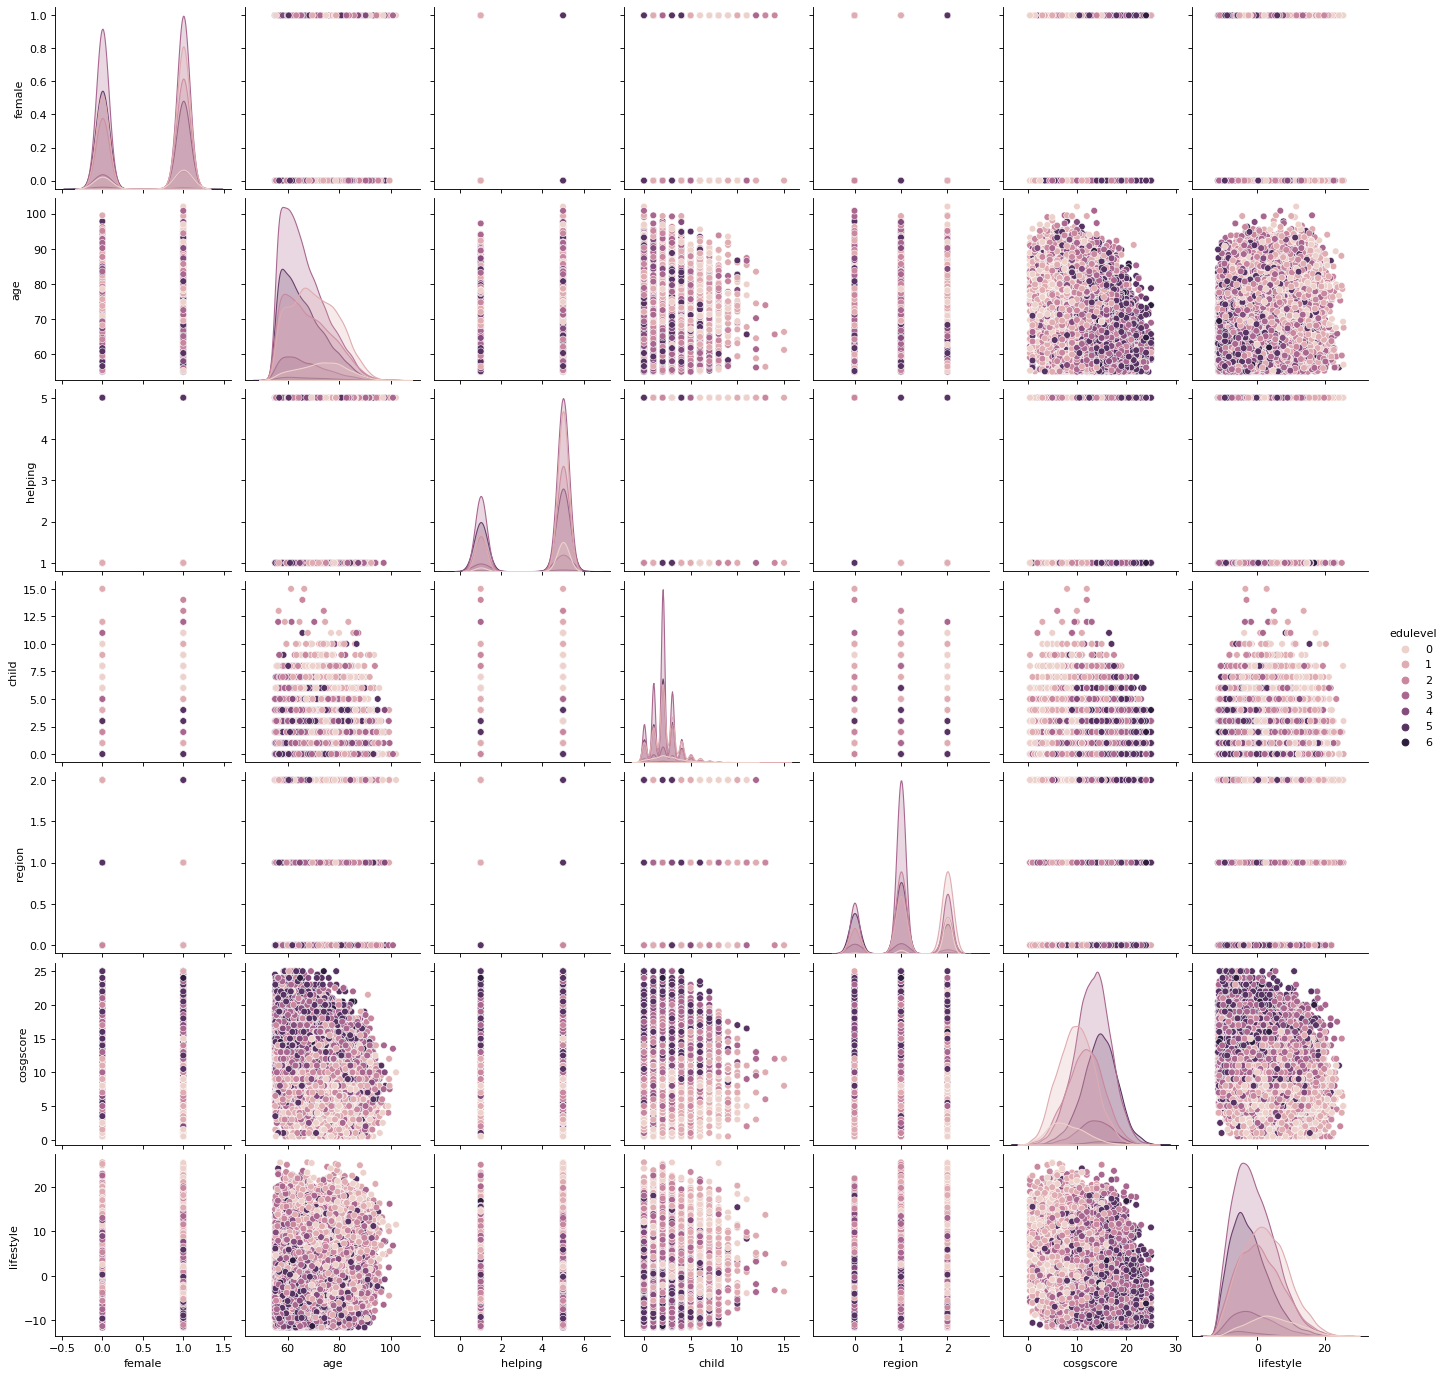

In [8]:
# Perform Principal Component Analysis (PCA) to reduce dimensionality
pre_pca_data = data_train[["depression","bmi2", "smoking","drinking","activity","casp","chronic_mod"]]
pre_data = data_train.drop(labels=["depression","bmi2", "smoking","drinking","activity","casp","chronic_mod"],axis=1).copy()

pca = PCA(n_components=1)
post_pca_data = pca.fit_transform(pre_pca_data)
data_train_post_pca = pre_data.assign(lifestyle=post_pca_data)

# Visualize relationships between variables after PCA
sns.pairplot(data_train_post_pca, hue="edulevel")

In [9]:
# Data transformation

# Standardize numerical data
num_pre = StandardScaler()

cat_ord = Pipeline([
    ("cat_encode", OrdinalEncoder())])

cat_hot = Pipeline([
    ("cat_encode", OneHotEncoder(drop="first"))])

# Pipeline for PCA
pca = Pipeline([
    ("pre_preocessing",ColumnTransformer([
    ("num_pre",num_pre,[5]),         # Apply StandardScaler to numerical column
    ("cat_ord", cat_ord, [0,1,4,6]), # Apply OrdinalEncoder to ordinal columns
    ("cat_hot", cat_hot, [2,3])])),  # Apply OneHotEncoder to categorical columns
    ("pca",PCA(n_components=1))      # Apply PCA to reduce dimensionality
])

# Column transformer for overall transformation
transformation = ColumnTransformer([
    ("cat_ord", cat_ord, [2]),       # Apply OrdinalEncoder to ordinal column
    ("cat_hot", cat_hot, [0,10,12]), # Apply OneHotEncoder to categorical columns
    ("pca",pca,[3,4,5,6,7,8,9])      # Apply PCA to summary features
                            #"depression","bmi2","smoking","drinking","activity","casp","chronic_mod" summarise lifestyle
],remainder="passthrough")           # Passthrough remaining columns as they are

# Model Fitting and Tuning

We will be evaluating the performance of our final model using the mean squared error (MSE) and $R^2$ values. The MSE is calculated as follows:

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^N (y_i-\hat{f}(x_i))^2,
$$

where $\mathbf{y} = y_1, \cdots, y_N$ represents the true value and $\hat{f}(x_i)$ is the predicted value from our model. On the other hand,  $R^2$ is defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{f}(x_i))^2}{\sum_{i=1}^N (y_i-\bar{y})^2}.
$$

This statistic describes how well the model fits the data. Our objective is to minimize the MSE value and maximize the $R^2$ value.

**Interpretation:**
- *Mean Squared Error (MSE):* The model achieves a low MSE on both training and test sets, indicating that the average squared difference between the actual cognitive scores and the predicted scores is minimal. This suggests that the model effectively captures the underlying patterns in the data and makes accurate predictions.
- *$R^2$ Score:* The $R^2$ score, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable (`cogscore`) that is predictable from the independent features. This model achieves relatively high $R^2$ scores on both the training and test sets, indicating that it explains a substantial portion of the variance in the cognitive scores. This underscores the model's ability to capture and model the complex relationships between the predictor variables and the target variable.

The choice of baseline model is the linear regression model, since it is the most simple model. The list of all the factors we are putting into our model will be reiterated here again:
<ol>
    <li> female </li>
    <li> age </li>
    <li> education level </li>
    <li> summary of lifestyle </li>
    <li> whether the participant is helping others </li>
    <li> number of children </li>
    <li> region which they live in </li>
</ol>

The code displayed below shows the fit for the linear regression model. 

In [10]:
# linear regression
linear = Pipeline([
    ("pre_processing", transformation),  # Preprocessing pipeline
    ("model", LinearRegression())        # Linear regression model
])

display(linear)

linear.fit(X_train,y_train)

# Calculate MSE and R^2 values for training and validation sets
model_fit(linear, X_train, y_train),model_fit(linear, X_val, y_val)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ord',
                                                  Pipeline(steps=[('cat_encode',
                                                                   OrdinalEncoder())]),
                                                  [2]),
                                                 ('cat_hot',
                                                  Pipeline(steps=[('cat_encode',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [0, 10, 12]),
                                                 ('pca',
                                                  Pipeline(steps=[('pre_preocessing',
                                                                   ColumnTransformer(transformers=[('num_pre',
                                                                                                    StandardScaler(),
                                                                                                    [5]),
                                                                                                   ('cat_ord',
                                                                                                    Pipeline(steps=[('cat_encode',
                                                                                                                     OrdinalEncoder())]),
                                                                                                    [0,
                                                                                                     1,
                                                                                                     4,
                                                                                                     6]),
                                                                                                   ('cat_hot',
                                                                                                    Pipeline(steps=[('cat_encode',
                                                                                                                     OneHotEncoder(drop='first'))]),
                                                                                                    [2,
                                                                                                     3])])),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  [3, 4, 5, 6, 7, 8, 9])])),
                ('model', LinearRegression())])

((11.169004067420913, 3.3420059945219895, 0.33290292056402215),
 (11.324148366630329, 3.365137198782589, 0.3237598674444887))

As we can see the MSE and $R^2$ values for this model on the training set, are approximately 11.2 and 0.33 respectively. On the validation set, we obtain MSE and $R^2$ values of 11.3 and 0.32 respectively.

We also explored alternative models such as cross-validated ridge, lasso, and elastic net regressions. However, their performances were either similar to the baseline model or worse. Therefore, we have opted not to consider these models. Finally, we have decided to use the polynomial model.

To implement the polynomial model, we need to adjust the data preprocessing slightly. Most of the steps from the previous section remain unchanged; however, we introduce an additional step in the pipeline to incorporate polynomial terms into the fitting process. One notable addition is the inclusion of interactions between `female`, `child`, and `helping`. This decision is based on [3], where evidence suggests that having more children reduces the risk of developing dementia later in life. Additionally, significant differences in dementia development rates have been observed between men (39.7%) and women (60.3%), indicating that including an interaction term may improve accuracy.

Additionally, according to a study conducted by the National Library of Medicine, available at [6], volunteering and contributing to the community may have a beneficial impact on cognitive abilities. In light of gender variances suggested in research findings such as those outlined in [7], we introduced an interaction term between the variables female and helping.

We observe that the only parameter requiring tuning is the degree of the polynomial. To determine the optimal degree, the following code helps identify the degree that minimizes the MSE value.

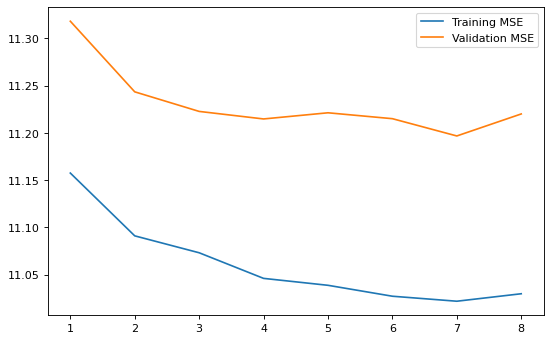

In [11]:
# Polynomial regression
MSEs_train = []
MSEs_val = []
pf_inter = Pipeline([
        ("one_hot", ColumnTransformer([
            ("cat_hot", cat_hot, [0,1])],remainder="passthrough")),
        ("poly",PolynomialFeatures(degree=2,interaction_only=True))
])

# Iterate over different polynomial degrees
for deg in range(8):
    pf = PolynomialFeatures(degree=deg+1)

    pca_poly = Pipeline([
        ("pca",pca),
        ("poly",pf)
    ])
    poly = Pipeline([
    ("pre_preocessing",ColumnTransformer([
    ("hot_encode", OneHotEncoder(drop="first"),[2]),
    ("ord_encode", OrdinalEncoder(),[1])],remainder="passthrough")),
    ("poly", pf)
    ])
    
    transformation_1 =  ColumnTransformer([
        ("poly",poly,[1,2,12]),
        ("inter", pf_inter,[0,10,11]),
        ("pca",pca_poly,[3,4,5,6,7,8,9]) 
    ])

    poly = Pipeline([
        ("pre_processing", transformation_1),
        ("model", LinearRegression())
    ])

    poly.fit(X_train,y_train)
    poly_fit_train = model_fit(poly, X_train, y_train)
    poly_fit_val = model_fit(poly, X_val, y_val)
    MSEs_train.append(poly_fit_train[0])
    MSEs_val.append(poly_fit_val[0])
    
plt.plot(range(1,9), MSEs_train, label="Training MSE")
plt.plot(range(1,9), MSEs_val, label="Validation MSE")
plt.legend()

From the graph above, we can clearly see that a degree 7 polynomial minimises the MSE value for both the train and validation sets. Hence we will pick that for our final model, and the code below displays the MSE and $R^2$ values considering both sets.

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('poly',
                                                  Pipeline(steps=[('pre_preocessing',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('hot_encode',
                                                                                                    OneHotEncoder(drop='first'),
                                                                                                    [2]),
                                                                                                   ('ord_encode',
                                                                                                    OrdinalEncoder(),
                                                                                                    [1])])),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=7))]),
                                                  [1, 2, 12]),
                                                 ('inter',
                                                  Pipeline(steps=[('one_hot',
                                                                   ColumnTransfo...
                                                                   Pipeline(steps=[('pre_preocessing',
                                                                                    ColumnTransformer(transformers=[('num_pre',
                                                                                                                     StandardScaler(),
                                                                                                                     [5]),
                                                                                                                    ('cat_ord',
                                                                                                                     Pipeline(steps=[('cat_encode',
                                                                                                                                      OrdinalEncoder())]),
                                                                                                                     [0,
                                                                                                                      1,
                                                                                                                      4,
                                                                                                                      6]),
                                                                                                                    ('cat_hot',
                                                                                                                     Pipeline(steps=[('cat_encode',
                                                                                                                                      OneHotEncoder(drop='first'))]),
                                                                                                                     [2,
                                                                                                                      3])])),
                                                                                   ('pca',
                                                                                    PCA(n_components=1))])),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=7))]),
                                                  [3, 4, 5, 6, 7, 8, 9])])),
               

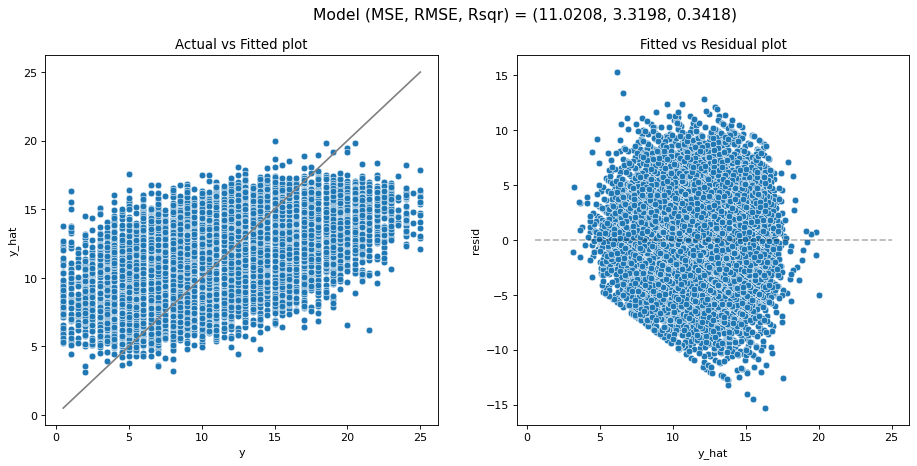

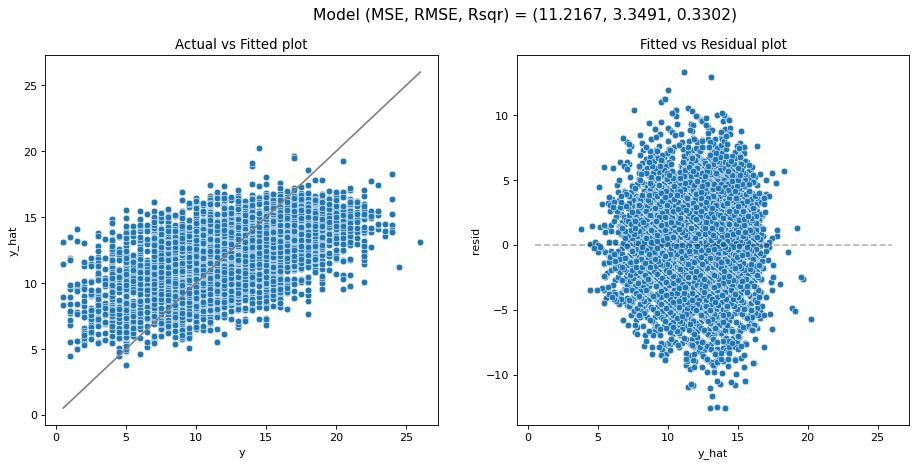

In [14]:
# Final polynomial model
pf = PolynomialFeatures(degree=7)

pca_poly = Pipeline([
        ("pca",pca),
        ("poly",pf)
    ])

poly = Pipeline([
    ("pre_preocessing",ColumnTransformer([
    ("hot_encode", OneHotEncoder(drop="first"),[2]),
    ("ord_encode", OrdinalEncoder(),[1])],remainder="passthrough")),
    ("poly", pf)
])

transformation_1 =  ColumnTransformer([
    ("poly",poly,[1,2,12]),
    ("inter", pf_inter,[0,10,11]),
    ("pca",pca_poly,[3,4,5,6,7,8,9])
])

poly = Pipeline([
    ("pre_processing", transformation_1),
    ("model", LinearRegression())
])

display(poly)

poly.fit(X_train,y_train)

# Calculate MSE and R^2 values for the final polynomial model
poly_fit_train = model_fit(poly, X_train, y_train,plot=True)
poly_fit_val = model_fit(poly, X_val, y_val,plot=True)

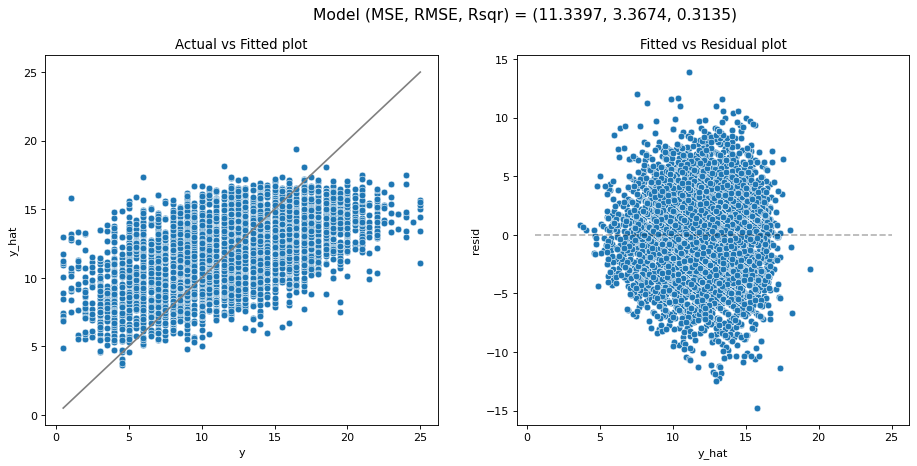

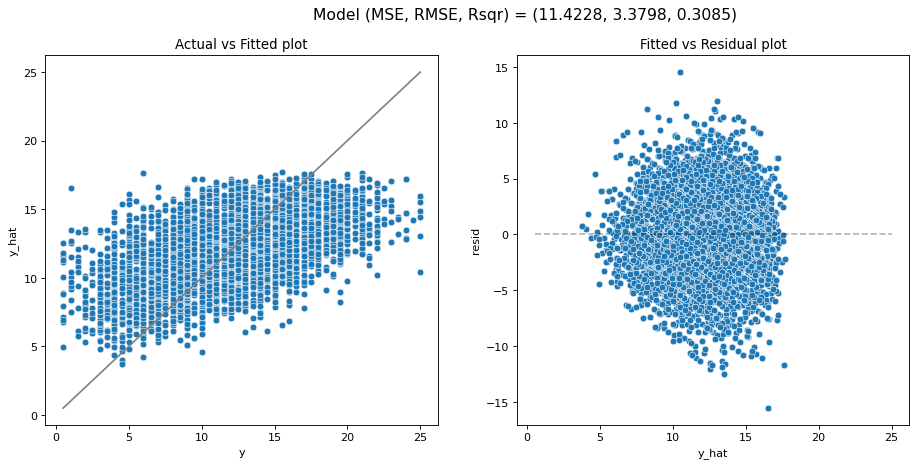

((11.339694298239218, 3.3674462576616153, 0.31353669605480217),
 (11.42283623823847, 3.3797686663791753, 0.30850358940066935))

In [15]:
model_fit(poly, X_test, y_test,plot=True),model_fit(linear, X_test, y_test,plot=True)

Finally, we can look at the test set to examine the performance of our final model. We can see that our model slightly outperforms the baseline model.

# Discussion & Conclusions

Our ultimate model is the carefully refined polynomial model, which incorporates a seven-degree polynomial for the variables `age`, `edu_level`, and `region`, due to their significant correlation with `cogscore`. Additionally, we have summerized various factors into `lifestyle` feature, and included it as a seven-degree polynomial model. Furthermore, interactions have been introduced for the features `female`, `helping`, and `child`. This comprehensive approach aims to enhance the accuracy of the model by considering intricate relationships and interactions among the key features associated with cognitive scores.

As mentioned in the introduction, our model is not exempt of limitations. This can be seen from the values obtained by the MSE and $R^2$. While, in an ideal model a low value for MSE and as close to one value for $R^2$ is desirable, the values obtained from our model can be justified. Dementia is caused by a myriad of different factors that with a simplistic machine learning techniques cannot be predicted perfectly. There may be different data features such as 'Neuroimaging' [2] and 'Biomarkers'[4] , which play a role in clinical dignosis of dementia, are not collected by the interviewers. Having access to these and similar extra features, can aid the predictive aspects of model development with hopes of better predictive model.

While preventing the risks of dementia poses a significant challenge, individuals can mitigate their risk by adopting positive lifestyle changes. These changes include engaging in regular exercise, refraining from smoking, moderating alcohol consumption, maintaining a balanced weight, and adhering to a healthy diet [5]. Additionally, governmental efforts can play a crucial role in discouraging smoking and unhealthy alcohol consumption through comprehensive advertising campaigns and by enhancing healthcare provisions. By promoting these measures, both individuals and governments can contribute to reducing the incidence of dementia and promoting overall public health.

# An Advance Model (extra)
Our model below, a Gradient Boosting Regressor, is a highly advanced model which through fitting and test has demonstrated remarkable predictive power for estimating cognitive scores, a proxy measure for dementia severity in this project. This advanced model significantly outperforms our previous methods, showcasing superior accuracy and robustness in analysis.

**How Gradient Boosting Works:**
Gradient boosting operates by sequentially fitting decision trees to the residuals (errors) of the preceding trees. Each subsequent tree focuses on minimizing the residual errors of the ensemble, gradually improving the overall predictive performance. By combining multiple weak learners (individual decision trees) into a strong ensemble model, gradient boosting can effectively model complex relationships and achieve high predictive accuracy.

**Model Performance Metrics:**
- Train Mean Squared Error (MSE): 9.59
- Test Mean Squared Error (MSE): 10.65
- Train $R^2$ Score: 0.43
- Test $R^2$ Score: 0.36

**Comparison with Previous Methods:**
When compared to our previous linear models and polynomial regression, the 'Gradient Boosting Regressor' stands out for its ability to capture complex nonlinear relationships and interactions among the predictor variables. While linear models and polynomial regression rely on simplistic assumptions about the data's structure, gradient boosting leverages an ensemble of decision trees, each trained sequentially to correct the errors of its predecessors. This iterative approach allows the model to adaptively learn from the data, capturing intricate patterns and nuances that linear models may overlook.

**Advantages of Gradient Boosting:**
Unlike linear models, which assume linear relationships between the features and the target variable, gradient boosting can capture nonlinear and non-monotonic relationships, allowing for more accurate and flexible modeling of the data.
Additionally, Gradient boosting is less susceptible to overfitting compared to polynomial regression, especially when dealing with high-dimensional or noisy data. Its ensemble approach helps mitigate overfitting by combining multiple weak learners, resulting in a more robust and generalized model.
Furthermore, Gradient boosting provides valuable insights into feature importance, allowing us to identify the most influential factors contributing to cognitive scores. This information can aid in understanding the underlying mechanisms driving dementia severity and inform targeted interventions and treatments.

**Model Evaluation:**
The performance metrics of our Gradient Boosting Regressor underscore its superiority over previous methods. With a low mean squared error (MSE) and high $R^2$ scores on both the training and test sets, the model demonstrates strong predictive accuracy and generalization capability. Its ability to effectively capture the complex relationships between the predictor variables and the target variable enhances our confidence in its predictive capabilities and utility in clinical and research settings.

**Conclusion:**
In conclusion, Gradient Boosting Regressor model is a highly complex model which represents a significant advancement in dementia severity prediction, outperforming traditional linear models and polynomial regression techniques. By leveraging the power of ensemble learning and adaptive boosting, this model offers superior accuracy, flexibility, and robustness, making it a valuable asset in early detection and assessment of dementia severity. Moving forward, further refinement and optimization of the model could unlock even greater insights into dementia risk factors and pave the way for personalized interventions and treatments tailored to individual patients.

In [16]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
data_2 = pd.read_csv("easyshare.csv")

# Preprocess the data
# Drop unnecessary columns
data_2.drop(["mergeid", "wave", "int_year", "country", "citizenship", "birth_country", "eduyears_mod", "bmi", "ever_smoked"], axis=1, inplace=True)
# Fill missing values
data_2.dropna(inplace=True)

# Define features and target variable
X_2 = data_2.drop("cogscore", axis=1)
y_2 = data_2["cogscore"]

# Split data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# Define and train the model
model_2 = GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, loss='squared_error', random_state=42)
model_2.fit(X_train_2, y_train_2)

# Make predictions
y_pred_train = model_2.predict(X_train_2)
y_pred_test = model_2.predict(X_test_2)

# Evaluate the model
mse_train = mean_squared_error(y_train_2, y_pred_train)
mse_test = mean_squared_error(y_test_2, y_pred_test)
r2_train = r2_score(y_train_2, y_pred_train)
r2_test = r2_score(y_test_2, y_pred_test)

# Print the evaluation metrics
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MSE: 9.591133991016031
Test MSE: 10.650770655096949
Train R^2: 0.4260477036640715
Test R^2: 0.36241799374356176


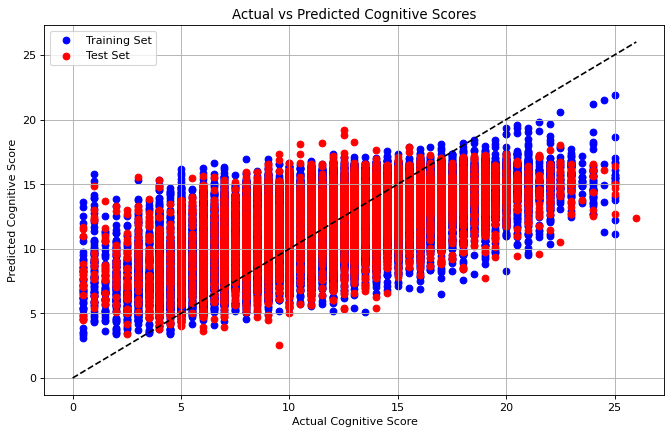

In [17]:
# Plotting
plt.figure(figsize=(10, 6))

# Training set
plt.scatter(y_train_2, y_pred_train, color='blue', label='Training Set')
# Test set
plt.scatter(y_test_2, y_pred_test, color='red', label='Test Set')

# Plotting the perfect fit line
max_val = max(max(y_train_2), max(y_test_2))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')

plt.title('Actual vs Predicted Cognitive Scores')
plt.xlabel('Actual Cognitive Score')
plt.ylabel('Predicted Cognitive Score')
plt.legend()
plt.grid(True)
plt.show()

# References

[1] World Health Organization, "Dementia," 2023. Available online: [link](https://www.who.int/news-room/fact-sheets/detail/dementia) (Accessed: 2024-03-13).

[2] Barkhof, Frederik. (2011). *Neuroimaging in dementia*. Berlin: Springer. ISBN: 3642008186.

[3] Basit, Saima, Wohlfahrt, Jan, & Boyd, Heather A. (2023). "Associations between parenthood and dementia in men and women: biology or confounding?" *BMC Neurology*, 23(1), 90. Available online: [link](https://doi.org/10.1186/s12883-023-03108-7) (Accessed: 2024-03-13). DOI: 10.1186/s12883-023-03108-7.

[4] Zetterberg, H. (2019). "Biomarkers in dementia." *Journal of the neurological sciences*, 405, 17-17. ISSN: 0022-510X. Publisher: Elsevier B.V.

[5] World Health Organization, "Adopting a Healthy Lifestyle Helps Reduce the Risk of Dementia," 2019. Available online: [link](https://www.who.int/news/item/14-05-2019-adopting-a-healthy-lifestyle-helps-reduce-the-risk-of-dementia) (Accessed: 2024-03-13).

[6] Griep Y, Hanson LM, Vantilborgh T, Janssens L, Jones SK, Hyde M. (2017). "Can volunteering in later life reduce the risk of dementia? A 5-year longitudinal study among volunteering and non-volunteering retired seniors." *PLoS One*, 12(3), e0173885. DOI: [10.1371/journal.pone.0173885](https://doi.org/10.1371/journal.pone.0173885). PMID: 28301554; PMCID: PMC5354395.

[7] Taniguchi, Hiromi. (2006). "Men's and women's volunteering: Gender differences in the effects of employment and family characteristics." *Nonprofit and voluntary sector quarterly*, 35(1), 83-101. Publisher: Sage Publications.


In [18]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf Final-project1.ipynb

[NbConvertApp] Converting notebook Final-project1.ipynb to pdf
[NbConvertApp] Writing 1395679 bytes to Final-project1.pdf
